In [ ]:
# TODO: tokenize the reports (otherwise unfair comparison with ngram and RNN)


In [1]:
import numpy as np
import dicom
import pandas as pd
import os
import matplotlib.pyplot as pl
from report_parser import parse_report
from PIL import Image
import tqdm
from collections import defaultdict
import pickle
import gzip
import random

from report_parser import parse_report

/scratch/cxr-baselines/cxr-baselines/venv_cxr/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
# data stored on our server
csv_file_path = '/crimea/mimic-cxr/cache/mimic-cxr-map.csv'
images_path = '/crimea/mimic-cxr/images'
reports_path = '/crimea/mimic-cxr/reports'

image_files  = set(os.listdir(images_path))
report_files = set(os.listdir(reports_path))

print('images:  %6d' % len( image_files)) #  91664
print('reports: %6d' % len(report_files)) # 206574

images:  473064
reports: 206574


In [3]:
df =  pd.read_csv(csv_file_path, sep=',', header=0)
df = df.loc[df['dicom_is_available'],:]
df.reset_index()
print(df.shape)                                             # (473057, 4)
display(df.head())

print('unique subjects: %6d' % len(set(df['subject_id'])))  # unique subjects:  63478
print('unique     rads: %6d' % len(set(df[    'rad_id'])))  # unique     rads: 206563
print('unique   dicoms: %6d' % len(set(df[  'dicom_id'])))  # unique   dicoms: 473057

(473057, 4)


,subject_id,rad_id,dicom_id,dicom_is_available
0,70233355,52727485,3b9565f5-69ab0d33-1a9d2d1b-bb09c424-7f0243e6,True
1,70233355,52727485,8074bd10-62acdde0-3df2608b-13ca2322-09ce372c,True
2,70233355,53378012,3108d905-782ffdc0-209309e8-2413eeb4-6bfb958a,True
3,70233355,53378012,40eab5a8-31446771-08c6b024-2717a65c-41f8c74f,True
4,70233355,55587989,cef1a7ea-8c7df75c-41070128-7cdf5c89-23682e1b,True


unique subjects:  63478
unique     rads: 206563
unique   dicoms: 473057


In [ ]:
# Load the image embeddings (to make sure we only look at images we have embeddings for)
with open('/crimea/wboag/2019/cxr/densenet121.pkl', 'rb') as f:
    densenet_vecs = pickle.load(f)
    
print(len(densenet_vecs))
dict(list(densenet_vecs.items())[:2])

In [ ]:
df = df[df.dicom_id.isin(dicom_ids)] # only rows that we have data for
df = df[df.dicom_id.isin(densenet_vecs)] # only images that we have densenet embeddings for

In [ ]:
# Load the image embeddings (to make sure we only look at images we have embeddings for)
with open('/crimea/wboag/2019/cxr/view_positions.pkl', 'rb') as f:
    view_positions = pickle.load(f)
    
print(len(view_positions))
dict(list(view_positions.items())[:2])

In [12]:
# patient -> list of (image,report) pairs
data = defaultdict(list)

columns = df.columns
for vals in tqdm.tqdm(df.values[:10]):
    row = dict(zip(columns,vals))
    dicom_file  = str(row['dicom_id'])+'.dcm.gz'
    report_file = str(row['rad_id'])+'.txt'
    if (dicom_file in image_files) and (report_file in report_files):
        
        # only AP images
        dicom_id = dicom_file.split('.')[0]
        view_position = view_positions[dicom_id]
        if view_position != 'AP':
            continue
        
        with open(os.path.join(reports_path,report_file)) as f:
            report_text = f.read().lower()
        if 'findings' in report_text:
            item = (dicom_file,report_file)
            data[row['subject_id']].append(item)
            
print(len(data))


 10%|█         | 1/10 [00:00<00:01,  6.07it/s]

PA
LL



 30%|███       | 3/10 [00:00<00:01,  5.93it/s]

LL
PA



 40%|████      | 4/10 [00:00<00:00,  6.10it/s]

PA



 50%|█████     | 5/10 [00:01<00:01,  2.66it/s]

LATERAL



 60%|██████    | 6/10 [00:02<00:01,  2.09it/s]

PA



 70%|███████   | 7/10 [00:03<00:01,  1.79it/s]

LATERAL



 80%|████████  | 8/10 [00:04<00:01,  1.71it/s]

PA



 90%|█████████ | 9/10 [00:05<00:00,  1.67it/s]

LATERAL



100%|██████████| 10/10 [00:06<00:00,  1.55it/s]


0


76283906 (6)
	-----------
	Patient ID: 76283906
	View Position: LATERAL


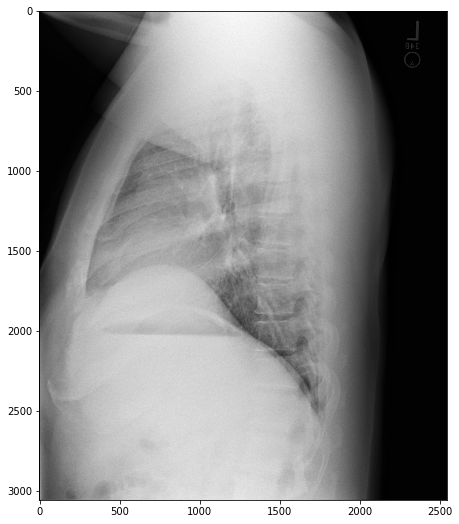

	Findings: the heart is mildly enlarged. the cardiomediastinal and hilar contours are within normal limits. lung volumes are low which accentuates bronchovascular markings. there is no focal consolidation, pleural effusion or pneumothorax.
	-----------
	Patient ID: 76283906
	View Position: PA


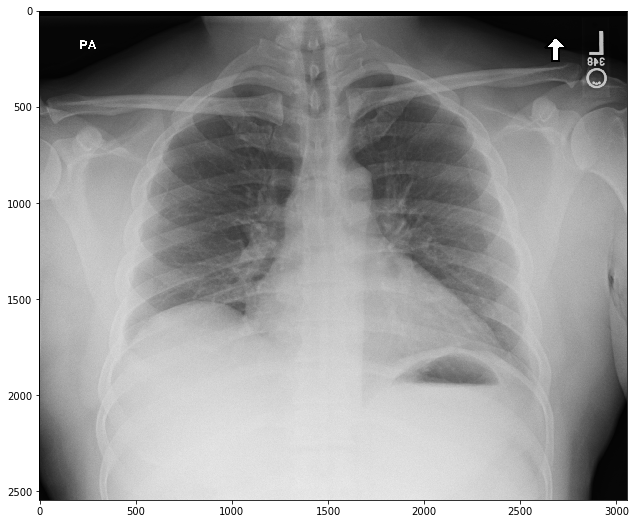

	Findings: the heart is mildly enlarged. the cardiomediastinal and hilar contours are within normal limits. lung volumes are low which accentuates bronchovascular markings. there is no focal consolidation, pleural effusion or pneumothorax.


75410091 (2)
	-----------
	Patient ID: 75410091
	View Position: PA


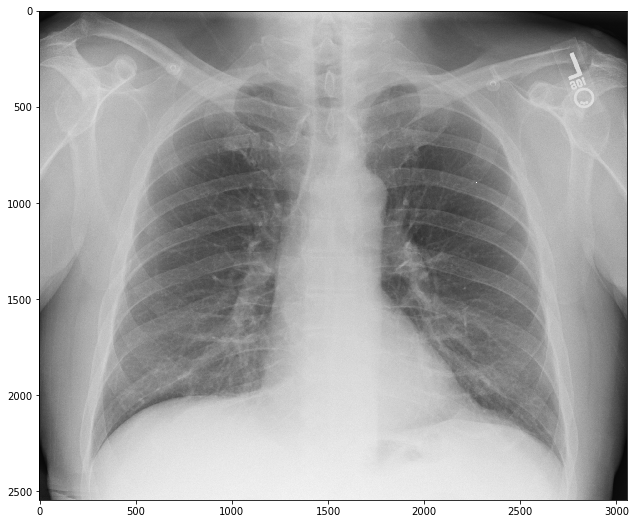

	Findings: the cardiomediastinal contours are within normal limits. the bilateral NAME are unremarkable. the lungs are clear without focal consolidation. opacity at the right cardiophrenic angle likely reflects crowding of normal bronchovascular structures. there NAME be bronchial wall thickening in the lower lobes. there is no evidence of pulmonary vascular congestion. there is no pneumothorax or pleural effusion.
	-----------
	Patient ID: 75410091
	View Position: LATERAL


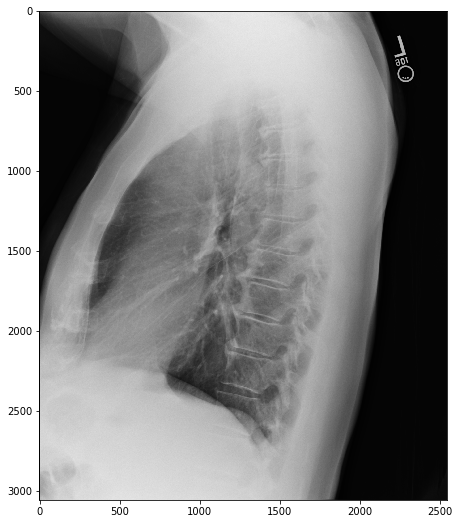

	Findings: the cardiomediastinal contours are within normal limits. the bilateral NAME are unremarkable. the lungs are clear without focal consolidation. opacity at the right cardiophrenic angle likely reflects crowding of normal bronchovascular structures. there NAME be bronchial wall thickening in the lower lobes. there is no evidence of pulmonary vascular congestion. there is no pneumothorax or pleural effusion.


78118917 (1)
	-----------
	Patient ID: 78118917
	View Position: AP


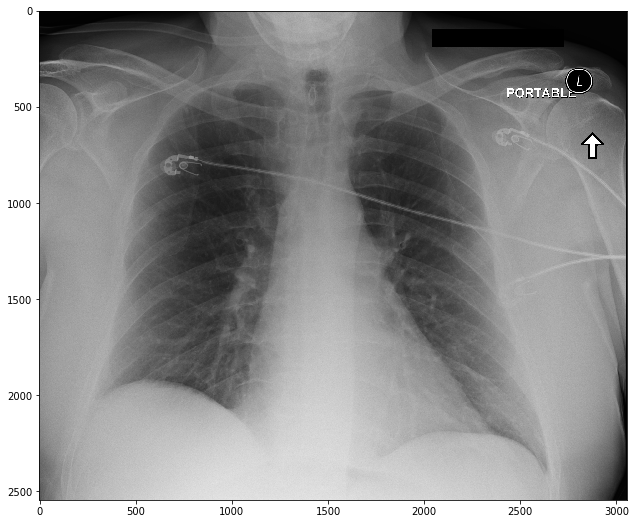

	Findings: portable frontal chest radiograph. there is no pleural effusion, pneumothorax or focal airspace consolidation. accounting for technique, the heart size is normal. the mediastinal and hilar structures are unremarkable. the pulmonary vascularity is normal.




In [7]:
# Load a few images to spot check
n = 3
first_n = dict(list(data.items())[:n])
for subject_id,items in first_n.items():
    
    print('%s (%d)' % (subject_id, len(items)))
    
    for (dicom_file,report_file) in items[:2]:
        dicom_path = os.path.join(images_path,dicom_file)
        dicom_img = gzip.open(dicom_path)
        plan = dicom.read_file(dicom_img, stop_before_pixels=False)
        view_position = plan.ViewPosition
        image = Image.fromarray(np.uint8(plan.pixel_array/plan.pixel_array.max()*255))
        parsed_report = parse_report(os.path.join(reports_path,report_file))

        if image != None:
            print('\t-----------')
            print('\tPatient ID:', plan.PatientID)
            print('\tView Position:', view_position)
            pl.figure(figsize=(18,9))
            pl.imshow(image)
            pl.show()
            if 'findings' in parsed_report:
                print("\tFindings:",parsed_report['findings'])
            else:
                print('\tFindings:')
                
    print('\t===================================================')            
    print('\n')

In [14]:
# List of unique dicom IDs
dicom_ids = set()
for subject_id,items in list(data.items()):
    for dicom_file,rad_file in items:
        dicom_id = dicom_file.split('.')[0]
        dicom_ids.add(dicom_id)
        
print(len(dicom_ids))

337459


In [15]:
subject_ids = list(data.keys())

In [16]:
# Create train/test split
subject_ids = list(subject_ids)
random.shuffle(subject_ids)

n = len(subject_ids)
split_ind = int(0.7*n)
train_ids = subject_ids[:split_ind ]
test_ids  = subject_ids[ split_ind:]

print('train:', len(train_ids))
print('test: ', len( test_ids))

train: 40566
test:  17386


In [17]:
# Write to file
df[df.subject_id.isin(train_ids)].to_csv('data/train.tsv', sep='\t')
df[df.subject_id.isin( test_ids)].to_csv('data/test.tsv' , sep='\t')